In [9]:
import pandas as pd 
import numpy as np
from datetime import datetime
from typing import Tuple
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

base_path = 'D:/dneuro/research/data'
output_path = 'D:/dneuro/research/output/summary/SRT_KOR/'

df_index = pd.read_excel(base_path + '/kospi200_historical_total_return_2000_2025_20250415.xlsx', index_col = 0)
df_return = pd.read_pickle(base_path + '/kospi200_historical_total_return_20050101_20250415.pkl')

df_fx = pd.read_pickle(base_path + '/kospi200_msfxkrw_index_price_2000_2025.pkl')

df_index.columns = ['return']
df_index *= 0.01

df_return = df_return.reindex(sorted(df_return.columns, key=str), axis=1)

def calculateBeta(stockData: pd.DataFrame, marketData: pd.DataFrame, evaluation_date: float, rolling_period: int) -> float:
    stockData.index = pd.to_datetime(stockData.index)
    marketData.index = pd.to_datetime(marketData.index)
    eval_date = datetime.strptime(str(int(evaluation_date)),'%Y%m%d')
    common_dates = list(stockData.index.intersection(marketData.index))
    common_dates = [a for a in common_dates if a <= eval_date]
    if len(common_dates) >= rolling_period:
        common_dates = common_dates[-rolling_period:]
        stockData = stockData[stockData.index.isin(common_dates)]
        marketData = marketData[marketData.index.isin(common_dates)]
        covariance = np.cov(stockData[1:].values.flatten(), marketData[1:].values.flatten())
        variance = np.var(marketData[1:].values.flatten())
        return covariance[0,1] / variance
    else:
        return np.nan

def calculate_rolling_beta(fundData: pd.DataFrame, marketData: pd.DataFrame, rolling_period: int) -> pd.DataFrame:
    fundData.index = pd.to_datetime(fundData.index)
    marketData.index = pd.to_datetime(marketData.index)
    common_dates = list(fundData.index.intersection(marketData.index))
    # common_dates = [a for a in common_dates if a <= eval_date]
    adj_fund_data_lst = []
    beta_lst = []
    
    for x in range(len(common_dates)):

        if x < rolling_period - 1:

            beta = 1
            adj_fund_data_lst.append(fundData.loc[common_dates[x]] / beta)
            beta_lst.append(beta)

        else:

            spot_beta_period = common_dates[x - rolling_period + 1:x+1]
        
            fund_spot_data = fundData[fundData.index.isin(spot_beta_period)]
            market_spot_data = marketData[marketData.index.isin(spot_beta_period)]
            # print(fund_spot_data)
            # print(market_spot_data)
            covariance = np.cov(fund_spot_data.values.flatten(), market_spot_data.values.flatten())
            variance = np.var(market_spot_data.values.flatten())
            beta = covariance[0,1] / variance
            # adj_fund_data_lst.append(fund_spot_data.loc[common_dates[x]] - beta * market_spot_data.loc[common_dates[x]])
            beta_lst.append(beta)

    # df_adj_stock_data = pd.DataFrame(adj_fund_data_lst, index = common_dates) 
    df_beta = pd.DataFrame({'beta': beta_lst}, index = common_dates)
    return df_beta

def build_usd_return(df_fx: pd.DataFrame, df_return: pd.DataFrame) -> pd.DataFrame:

    common_dates = df_fx.index.intersection(df_return.index)

    df_fx_filtered = df_fx.loc[common_dates]

    df_return_filtered = df_return.loc[common_dates]

    tickers = df_return.columns.tolist()
    df_fx_filtered['pct_change_plus_1'] = df_fx_filtered['pct_change'] + 1

    df_return_filtered = (1+df_return_filtered).multiply(df_fx_filtered['pct_change_plus_1'], axis=0) - 1
    df_return_filtered = df_return_filtered[tickers]
    return df_return_filtered

def build_same_setting_dataframe(df_a: pd.DataFrame, df_b: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]: 
    # Find common tickers using set intersection (faster than list comprehension)
    common_tickers = sorted(set(df_a.columns) & set(df_b.columns))

    # Select only common tickers in sorted order
    return df_a[common_tickers], df_b[common_tickers]
    
 
def calc_portfolio_return(df_return: pd.DataFrame, df_factor: pd.DataFrame, lagging: int = 0)-> pd.DataFrame:

    df_weight_mul_return = df_factor * df_return.shift(-lagging)
    # df_valid_mrg_buy_plus_sell_rolling_5day_std_div_rolling_40day_std_filtered_long_10_short_10_ret_mul.tail()
    df_portfolio_return = df_weight_mul_return.sum(axis=1)
    df_portfolio_return = df_portfolio_return.shift(lagging)
    df_portfolio_return = pd.DataFrame(df_portfolio_return, columns = ['return'], index = df_portfolio_return.index)

    return df_portfolio_return

def calculate_inverse_vol_weights(vol1: float, vol2: float):

    # Calculate the total magnitude of both numbers
    sum_of_inverse_vol = 1 / vol1 + 1 / vol2
    
    w1 = 1 / vol1 / sum_of_inverse_vol  # Positive number: weight proportional to magnitude
   
    w2 = 1 - w1  # Adjust w2 so that w1 + w2 = 1
    
    return w1, w2

df_usd_return = build_usd_return(df_fx, df_return)
df_usd_return.index = pd.to_datetime(df_usd_return.index)

In [10]:
# Universe: KOSPI 200 Constituents Only
# Trade Value Filter: Average Trade Value of USD 8M
# Strategy Type: Long-Short Delta Neutral 
# Main Data: Korea Short Sell Data
# Average number of Holdings: between 80 and 100
# Average daily turnover: about 26.28%
# Strategy recent 5-year Sharpe Ratio: 1.23
# Strategy recent 10-year Sharpe Ratio: 0.90
# Benchmark Index (KOSPI200) recent 5-year Sharpe Ratio: 0.42
# Benchmark Index (KOSPI200) recent 10-year Sharpe Ratio: 0.38
# Target Portfolio Size: 6.4M USD (1% of average trade value * 80 holdings)

1.8414985191484556
2.0255944618128585


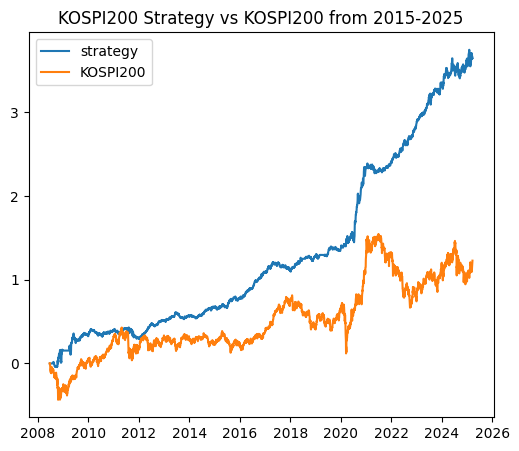

In [11]:
df_factor1 = pd.read_excel(output_path + 'kospi200_SRT_factor1_long_short_weights.xlsx', index_col = 0)

df_factor1.index = pd.to_datetime(df_factor1.index)
df_index.index = pd.to_datetime(df_index.index)
# df_factor3.index = pd.to_datetime(df_factor3.index)

df_usd_return = build_usd_return(df_fx, df_return)
df_usd_return.index = pd.to_datetime(df_usd_return.index)

common_dates = df_factor1.index \
.intersection(df_index.index)

df_factor1 = df_factor1.loc[common_dates]
df_index = df_index.loc[common_dates]


df_weights = 1.0 * df_factor1 

common_dates = df_usd_return.index.intersection(df_weights.index)
df_weights = df_weights.loc[common_dates]
df_usd_return_filtered = df_usd_return.loc[common_dates]

df_usd_return_filtered, df_weights = build_same_setting_dataframe(df_usd_return_filtered, df_weights)
df_portfolio_return = calc_portfolio_return(df_usd_return_filtered, df_weights, 1)

print((df_portfolio_return.loc[datetime.strptime('20150101','%Y%m%d'):]['return'].mean()*250) / (df_portfolio_return.loc[datetime.strptime('20150101','%Y%m%d'):]['return'].std() * np.sqrt(250)))
print((df_portfolio_return.loc[datetime.strptime('20200101','%Y%m%d'):]['return'].mean()*250) / (df_portfolio_return.loc[datetime.strptime('20200101','%Y%m%d'):]['return'].std() * np.sqrt(250)))

fig = plt.figure(figsize=(6, 5))

plt.plot((df_portfolio_return['return'] + 1).cumprod() - 1, label = 'strategy')
plt.plot((df_index['return'] + 1).cumprod() - 1, label = 'KOSPI200')

plt.title('KOSPI200 Strategy vs KOSPI200 from 2015-2025')
plt.legend()
plt.show() 


# Number of Holdings

<Axes: >

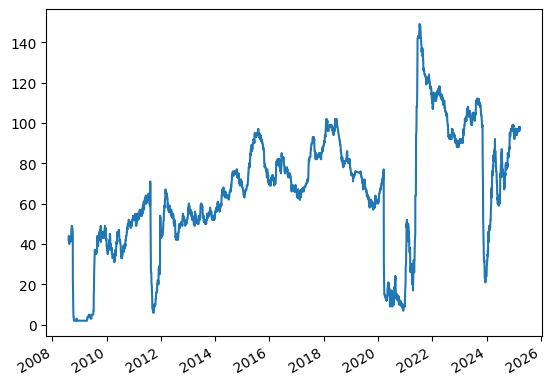

In [12]:
df_weights_filtered = df_weights.dropna(how='all')
df_weights_count = (df_weights_filtered != 0).astype(int).sum(axis=1) 
df_weights_count.plot()

# Portfolio Weight

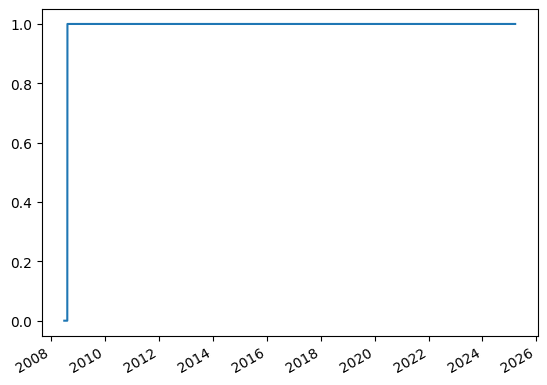

In [13]:
df_portfolio_weights = df_weights.fillna(method='ffill').abs().sum(axis=1).plot()

# Portfolio Turnover

0.26281567075773943


<Axes: >

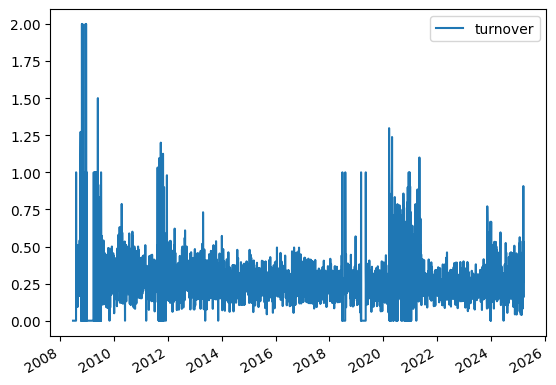

In [14]:
df_turnover = df_weights.fillna(0).diff().abs().sum(axis=1)
df_turnover = pd.DataFrame(df_turnover, columns = ['turnover'])
print(df_turnover['turnover'].mean())
df_turnover.plot()

# Fee Adjusted Return

Strategy 10-year Sharpe Ratio:  0.8175880952151457
Strategy 5-year Sharpe Ratio:  1.0842126485494716
BM 10-year Sharpe Ratio:  0.4213098773172397
BM 5-year Sharpe Ratio:  0.38514482974046793


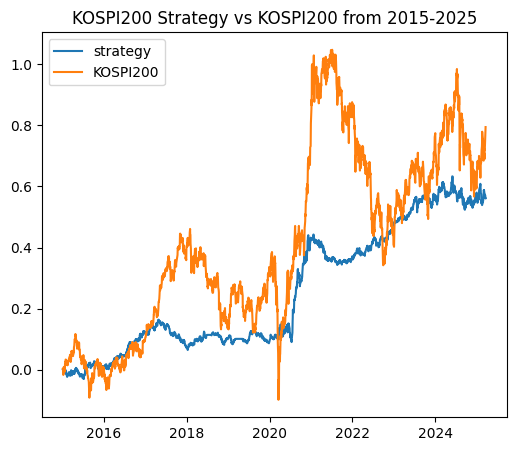

In [15]:

df_portfolio_return['adj_return'] = df_portfolio_return['return'] - df_turnover['turnover'] * 0.0009

print('Strategy 10-year Sharpe Ratio: ', (df_portfolio_return.loc[datetime.strptime('20150101','%Y%m%d'):]['adj_return'].mean()*250) / (df_portfolio_return.loc[datetime.strptime('20150101','%Y%m%d'):]['adj_return'].std() * np.sqrt(250)))
print('Strategy 5-year Sharpe Ratio: ', (df_portfolio_return.loc[datetime.strptime('20200101','%Y%m%d'):]['adj_return'].mean()*250) / (df_portfolio_return.loc[datetime.strptime('20200101','%Y%m%d'):]['adj_return'].std() * np.sqrt(250)))

print('BM 10-year Sharpe Ratio: ', (df_index.loc[datetime.strptime('20150101','%Y%m%d'):]['return'].mean()*250) / (df_index.loc[datetime.strptime('20150101','%Y%m%d'):]['return'].std() * np.sqrt(250)))
print('BM 5-year Sharpe Ratio: ', (df_index.loc[datetime.strptime('20200101','%Y%m%d'):]['return'].mean()*250) / (df_index.loc[datetime.strptime('20200101','%Y%m%d'):]['return'].std() * np.sqrt(250)))

fig = plt.figure(figsize=(6, 5))

plt.plot((df_portfolio_return['adj_return'].loc[datetime.strptime('20150101','%Y%m%d'):] + 1).cumprod() - 1, label = 'strategy')
plt.plot((df_index['return'].loc[datetime.strptime('20150101','%Y%m%d'):] + 1).cumprod() - 1, label = 'KOSPI200')

plt.title('KOSPI200 Strategy vs KOSPI200 from 2015-2025')
plt.legend()
plt.show() 

# Beta Adjusted Return

10-year Sharpe Ratio:  0.9021206011368559
5-year Sharpe Ratio:  1.2339220219085374
10-year return:  0.6287608228359092
5-year return:  0.49675225314930427


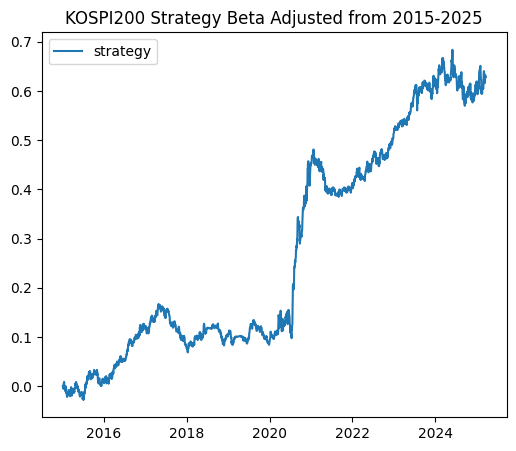

In [16]:
df_portfolio_adj_return = df_portfolio_return[['adj_return']].fillna(0)

df_beta = calculate_rolling_beta(df_portfolio_adj_return, df_index, 60)

df_portfolio_adj_return['beta_adj_return'] = df_portfolio_adj_return['adj_return'] - df_beta['beta'] * df_index['return']

print('10-year Sharpe Ratio: ', (df_portfolio_adj_return.loc[datetime.strptime('20150101','%Y%m%d'):]['beta_adj_return'].mean()*250) / (df_portfolio_adj_return.loc[datetime.strptime('20150101','%Y%m%d'):]['beta_adj_return'].std() * np.sqrt(250)))
print('5-year Sharpe Ratio: ', (df_portfolio_adj_return.loc[datetime.strptime('20200101','%Y%m%d'):]['beta_adj_return'].mean()*250) / (df_portfolio_adj_return.loc[datetime.strptime('20200101','%Y%m%d'):]['beta_adj_return'].std() * np.sqrt(250)))

print('10-year return: ', ((df_portfolio_adj_return.loc[datetime.strptime('20150101','%Y%m%d'):]['beta_adj_return'] + 1).cumprod() - 1).iloc[-1])
print('5-year return: ', ((df_portfolio_adj_return.loc[datetime.strptime('20200101','%Y%m%d'):]['beta_adj_return'] + 1).cumprod() - 1).iloc[-1])

fig = plt.figure(figsize=(6, 5))

plt.plot((df_portfolio_adj_return['beta_adj_return'].loc[datetime.strptime('20150101','%Y%m%d'):] + 1).cumprod() - 1, label = 'strategy')

plt.title('KOSPI200 Strategy Beta Adjusted from 2015-2025')
plt.legend()
plt.show() 